# Char RNN

En esta notebook, haremos un clasificador en base a caracteres



In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Primero, entrenemos una LSTM para caracteres

In [2]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences


def tokenize(tweet, **kwargs):
    
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    for token in tokens:
        if token[0] == "#":
            ret.append(token[1:])
        elif token[0] == "@":
            ret.append("@user")
        else:
            ret.append(token)
    
    return ret

tokenize_args = {"preserve_case": True, "reduce_len": True, "strip_handles": False}

tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]
tokens_test = [tokenize(tweet, **tokenize_args) for tweet in df_test["text"].values]
text_train = [" ".join(t) for t in tokens_train]
text_dev = [" ".join(t) for t in tokens_dev]
text_test = [" ".join(t) for t in tokens_test]

Using TensorFlow backend.


Probemos haciendo stemming primero

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True)

char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)
X_char_test = char_tokenizer.texts_to_sequences(text_test)

Hagamos un histograma de la cantidad de caracteres primero


(array([283., 829., 855., 806., 556., 307., 247., 243., 257., 117.]),
 array([  6. ,  37.2,  68.4,  99.6, 130.8, 162. , 193.2, 224.4, 255.6,
        286.8, 318. ]),
 <a list of 10 Patch objects>)

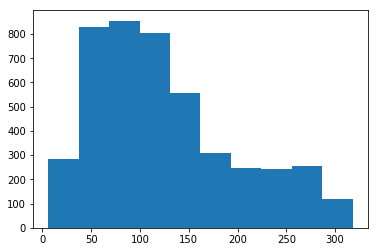

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in X_char_train])

Cortemos en 250

In [5]:
from keras.utils import to_categorical
import numpy as np

max_charlen = 250

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)
X_char_test = pad_sequences(X_char_test, maxlen=max_charlen)


Ahora, calculemos los inputs de ElMO

Hagamos un primer modelo con múltiple inputs.

In [6]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding,
    CuDNNLSTM, Conv1D, MaxPooling1D, Input, Concatenate)
from keras.optimizers import Adam

optimizer_args = {
    "lr": 0.001,
    "decay": 0.001,
}

embedding_dim = 150


input_char = Input(shape=(max_charlen,))
x = Embedding(vocab_size, embedding_dim)(input_char)
x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x) 
x = MaxPooling1D(pool_size=3)(x)
x = Bidirectional(CuDNNLSTM(128))(x)
x = Dropout(0.75)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_char], outputs=[output])
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit([X_char_train], y_train, validation_data=(X_char_dev, y_dev), epochs=15, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 6s 1ms/step - loss: 0.6819 - acc: 0.5753 - val_loss: 0.6817 - val_acc: 0.5580
Epoch 2/15
4500/4500 [==============================] - 2s 551us/step - loss: 0.6570 - acc: 0.6276 - val_loss: 0.6892 - val_acc: 0.5700
Epoch 3/15
4500/4500 [==============================] - 2s 555us/step - loss: 0.6330 - acc: 0.6560 - val_loss: 0.6254 - val_acc: 0.6360
Epoch 4/15
4500/4500 [==============================] - 2s 545us/step - loss: 0.5935 - acc: 0.6960 - val_loss: 0.6090 - val_acc: 0.6700
Epoch 5/15
4500/4500 [==============================] - 2s 545us/step - loss: 0.5568 - acc: 0.7291 - val_loss: 0.5706 - val_acc: 0.7100
Epoch 6/15
4500/4500 [==============================] - 2s 548us/step - loss: 0.5265 - acc: 0.7496 - val_loss: 0.6243 - val_acc: 0.6420
Epoch 7/15
4500/4500 [==============================] - 2s 553us/step - loss: 0.4812 - acc: 0.7851 - val_loss: 0.5547 - val_acc: 0.7280
Epo

In [8]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_char_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_char_test, y_test)

Evaluación sobre dev
500/500 [==============================] - 0s 224us/step
Loss           : 0.8566
Accuracy       : 0.7560
Precision(1)   : 0.7336
Precision(1)   : 0.7727
Precision(avg) : 0.7532

Recall(1)      : 0.7072
Recall(0)      : 0.7950
Recall(avg)    : 0.7511

F1(1)          : 0.7202
F1(0)          : 0.7837
F1(avg)        : 0.7519


Evaluación sobre test
1600/1600 [==============================] - 0s 207us/step
Loss           : 1.0603
Accuracy       : 0.6681
Precision(1)   : 0.6035
Precision(1)   : 0.7093
Precision(avg) : 0.6564

Recall(1)      : 0.5697
Recall(0)      : 0.7372
Recall(avg)    : 0.6535

F1(1)          : 0.5861
F1(0)          : 0.7230
F1(avg)        : 0.6546


## Usando Stemming

Veamos qué pasa si hacemos stemming sobre el texto

In [9]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('spanish')

stemmed_tokens_train = [[stemmer.stem(t) for t in text] for text in tokens_train]
stemmed_tokens_dev = [[stemmer.stem(t) for t in text] for text in tokens_dev]
stemmed_tokens_test = [[stemmer.stem(t) for t in text] for text in tokens_test]

stemmed_text_train = [" ".join(t) for t in stemmed_tokens_train]
stemmed_text_dev = [" ".join(t) for t in stemmed_tokens_dev]
stemmed_text_test = [" ".join(t) for t in stemmed_tokens_test]

In [10]:

vocab_size = 125

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True)

char_tokenizer.fit_on_texts(stemmed_text_train)

X_char_train = char_tokenizer.texts_to_sequences(stemmed_text_train)
X_char_dev = char_tokenizer.texts_to_sequences(stemmed_text_dev)
X_char_test = char_tokenizer.texts_to_sequences(stemmed_text_test)
max_charlen = 250

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)
X_char_test = pad_sequences(X_char_test, maxlen=max_charlen)


In [11]:

embedding_dim = 128


optimizer_args = {
    "lr": 0.001,
    "decay": 0.01,
}

input_char = Input(shape=(max_charlen,))
x = Embedding(vocab_size, embedding_dim)(input_char)
x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x) 
x = MaxPooling1D(pool_size=3)(x)
x = Bidirectional(CuDNNLSTM(128))(x)
x = Dropout(0.75)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
 
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_char], outputs=[output])
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

model.fit([X_char_train], y_train, validation_data=(X_char_dev, y_dev), epochs=15, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 3s 711us/step - loss: 0.6750 - acc: 0.5953 - val_loss: 0.6734 - val_acc: 0.5860
Epoch 2/15
4500/4500 [==============================] - 3s 559us/step - loss: 0.6511 - acc: 0.6333 - val_loss: 0.6553 - val_acc: 0.6060
Epoch 3/15
4500/4500 [==============================] - 2s 539us/step - loss: 0.6224 - acc: 0.6682 - val_loss: 0.6443 - val_acc: 0.6120
Epoch 4/15
4500/4500 [==============================] - 3s 557us/step - loss: 0.5926 - acc: 0.6916 - val_loss: 0.6375 - val_acc: 0.6360
Epoch 5/15
4500/4500 [==============================] - 2s 549us/step - loss: 0.5728 - acc: 0.7173 - val_loss: 0.6103 - val_acc: 0.6860
Epoch 6/15
4500/4500 [==============================] - 2s 555us/step - loss: 0.5489 - acc: 0.7380 - val_loss: 0.5858 - val_acc: 0.6980
Epoch 7/15
4500/4500 [==============================] - 3s 563us/step - loss: 0.5187 - acc: 0.7593 - val_loss: 0.5818 - val_acc: 0.7060
E

In [12]:
from hate.utils import print_evaluation

print("Evaluación sobre dev")
print_evaluation(model, X_char_dev, y_dev)
print("\n\nEvaluación sobre test")
print_evaluation(model, X_char_test, y_test)

Evaluación sobre dev
500/500 [==============================] - 0s 219us/step
Loss           : 0.5436
Accuracy       : 0.7560
Precision(1)   : 0.7577
Precision(1)   : 0.7549
Precision(avg) : 0.7563

Recall(1)      : 0.6622
Recall(0)      : 0.8309
Recall(avg)    : 0.7465

F1(1)          : 0.7067
F1(0)          : 0.7911
F1(avg)        : 0.7489


Evaluación sobre test
1600/1600 [==============================] - 0s 210us/step
Loss           : 0.6364
Accuracy       : 0.6806
Precision(1)   : 0.6319
Precision(1)   : 0.7072
Precision(avg) : 0.6696

Recall(1)      : 0.5409
Recall(0)      : 0.7787
Recall(avg)    : 0.6598

F1(1)          : 0.5829
F1(0)          : 0.7413
F1(avg)        : 0.6621


No parece mejorar mucho stemming

## Error Analysis

Vamos a ver los tweets con mayores errores

In [16]:
df_dev["proba"] = model.predict_proba(X_char_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 45
Falsos positivos: 61


,pred_true,pred_false
real,,
hs=1,177,45
hs=0,61,217


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [17]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.001557
22328,"@EvaMari86958216 @alex_UCM1 Yo también creo que tú eres una mala puta y también me quedo corto, además de mal educada...",0.005359
23783,Lo mejor de todo ver a Anabel con cara de asco jeje fijo que te lo mereces zorra https://t.co/3MMQKUAWYG,0.005577
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.007759
21297,@valevitarb es que tú eres LA perra MAYOR 🐕✨✨✨✨✨,0.020126
24434,"""Hace tanto calor que podría matar a un árabe indiferentemente. (Referencia de """"El extranjero"""")""",0.023323
24895,"@xSuzuHopkins @gimme5yens El de mi polla a granel. Que te calles, virgen.",0.027346
22592,o sea tantos arabes q hay en venezuela y no pueden hacer un atentado decente q pasa ?????????,0.028854
22953,Le puedes dar un pez a un hombre y comerá un día Como le des una caña a un subsahariano fabricará una lanza y atravesará a un guardia civil,0.041712


¿Cómo los tokenizamos?

In [20]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Elmo y OOV words

¿Qué hace elmo con palabras extrañas como "negratas", "subsaharianos", etc?

In [59]:
vocabulary = e.word_lexicon.keys()

"negratas" in vocabulary

False

In [60]:
"subsahariano" in vocabulary

False

Ok. Estamos perdiendo información con esto

In [51]:
vecs = e.sents2elmo([["negratas"], ["subsahariano"]], 2)

In [52]:
vecs[0].shape, vecs[1].shape

((1, 1024), (1, 1024))

In [57]:
v1 = vecs[0].reshape(-1)
v2 = vecs[1].reshape(-1)

sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

sim

0.7698738

## Falsos negativos

In [63]:
pd.set_option('max_colwidth', 200)
false_positives[["text", "proba"]]

,text,proba
id,,
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.958672
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.955924
21966,"escúchame ya me jodería jajajajajajajajajajajajajaja si pa ti enseñar es ser una guarra yo soy biennnn guarra, menos mal que no me respeto que si no... https://t.co/yt5fHp99b7",0.946862
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.944250
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.941651
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.930660
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.920149
24529,@desoir2525 Cállate rata MUDera.eres escoria.,0.908138
21892,@saancisco Callate puta tu eres el traidor.,0.878067


## Usando las traducciones?

Probemos, ya que estamos...

# Conclusiones

Sirvió mejorar el preprocesamiento. Quedamos en pérdida ~0.43

No estarían convenciendo las traducciones...

Diría que intentemos un ensemble con caracteres o n-gramas.